# Bike Sharing Assignment

## Bussiness Objective 

You are required to model the demand for shared bikes with the available independent variables. It will be used by the management to understand how exactly the demands vary with different features. They can accordingly manipulate the business strategy to meet the demand levels and meet the customer's expectations. Further, the model will be a good way for management to understand the demand dynamics of a new market. 

## Reading the data

In [94]:
#import the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#supress the warnings
import warnings 
warnings.filterwarnings('ignore')

In [95]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor


In [96]:
#import the dataset
day = pd.read_csv('day.csv')
day.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [97]:
#so that we can see all the rows and columns by scrolling
pd.options.display.max_columns= None
pd.options.display.max_rows= None

## Data Understanding and Cleaning

In [98]:
#based on the bussiness objective lets drop the non essential columns

#we want to predict the values for cnt, we can drop the casual and registered columns
#instant is just an index, so we dont need it
#all the important information has been captured from the date column and stored in weekday, holiday, year, mnth and workingday

day.drop(['instant','dteday','casual','registered'], axis = 1, inplace = True)

In [99]:
day.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,1600


In [100]:
day.shape

(730, 12)

In [101]:
day.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      730 non-null    int64  
 1   yr          730 non-null    int64  
 2   mnth        730 non-null    int64  
 3   holiday     730 non-null    int64  
 4   weekday     730 non-null    int64  
 5   workingday  730 non-null    int64  
 6   weathersit  730 non-null    int64  
 7   temp        730 non-null    float64
 8   atemp       730 non-null    float64
 9   hum         730 non-null    float64
 10  windspeed   730 non-null    float64
 11  cnt         730 non-null    int64  
dtypes: float64(4), int64(8)
memory usage: 68.6 KB


In [102]:
#lets check if it has any missing values
day.isnull().sum()

season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
cnt           0
dtype: int64

In [103]:
#lets check the datatypes
day.dtypes

season          int64
yr              int64
mnth            int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
cnt             int64
dtype: object

In [104]:
day.describe()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,2.498630,0.500000,6.526027,0.028767,2.997260,0.683562,1.394521,20.319259,23.726322,62.765175,12.763620,4508.006849
std,1.110184,0.500343,3.450215,0.167266,2.006161,0.465405,0.544807,7.506729,8.150308,14.237589,5.195841,1936.011647
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.424346,3.953480,0.000000,1.500244,22.000000
25%,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,13.811885,16.889713,52.000000,9.041650,3169.750000
50%,3.000000,0.500000,7.000000,0.000000,3.000000,1.000000,1.000000,20.465826,24.368225,62.625000,12.125325,4548.500000
75%,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,26.880615,30.445775,72.989575,15.625589,5966.000000
max,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,35.328347,42.044800,97.250000,34.000021,8714.000000


In [105]:
#lets get an idea about the values present in the columms
day.nunique().sort_values(ascending = True)

yr              2
holiday         2
workingday      2
weathersit      3
season          4
weekday         7
mnth           12
temp          498
hum           594
windspeed     649
atemp         689
cnt           695
dtype: int64

In [106]:
#lets standardize the precision for temp, atemp, hum, windspeed 
day[['temp', 'atemp', 'hum', 'windspeed']].head()

,temp,atemp,hum,windspeed
0,14.110847,18.18125,80.5833,10.749882
1,14.902598,17.68695,69.6087,16.652113
2,8.050924,9.47025,43.7273,16.636703
3,8.200000,10.60610,59.0435,10.739832
4,9.305237,11.46350,43.6957,12.522300


In [107]:
#lets round the digits, as for prediction we dont need so much precision 
day[['temp', 'atemp', 'hum', 'windspeed']] = day[['temp', 'atemp', 'hum', 'windspeed']].round(decimals = 0)

In [108]:
#lets verify the operations
day[['temp', 'atemp', 'hum', 'windspeed']].head()

,temp,atemp,hum,windspeed
0,14.0,18.0,81.0,11.0
1,15.0,18.0,70.0,17.0
2,8.0,9.0,44.0,17.0
3,8.0,11.0,59.0,11.0
4,9.0,11.0,44.0,13.0


## Data Visualization

In [109]:
#lets visualize the data to get an overall picture

In [110]:
day.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,0,1,0,6,0,2,14.0,18.0,81.0,11.0,985
1,1,0,1,0,0,0,2,15.0,18.0,70.0,17.0,801
2,1,0,1,0,1,1,1,8.0,9.0,44.0,17.0,1349
3,1,0,1,0,2,1,1,8.0,11.0,59.0,11.0,1562
4,1,0,1,0,3,1,1,9.0,11.0,44.0,13.0,1600


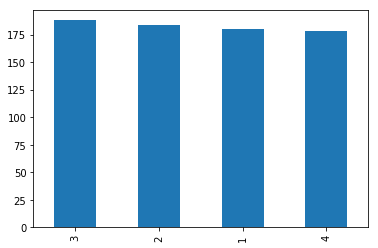

In [111]:
day.season.value_counts().plot(kind='bar')
#roughly all seasons last for the same duration

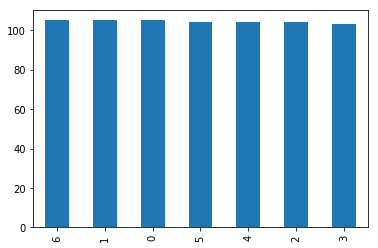

In [112]:
day.weekday.value_counts().plot(kind='bar')

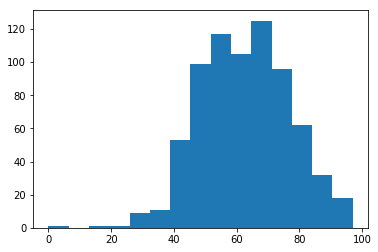

In [113]:
#lets see the distribution of humidity
plt.hist(day.hum,bins=15)
plt.show()

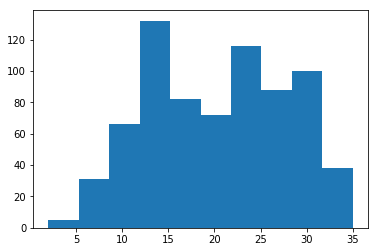

In [114]:
#lets see the distribution of temp
plt.hist(day.temp)
plt.show()

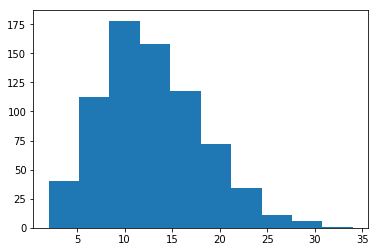

In [115]:
#lets see the distribution of speed
plt.hist(day.windspeed)
plt.show()

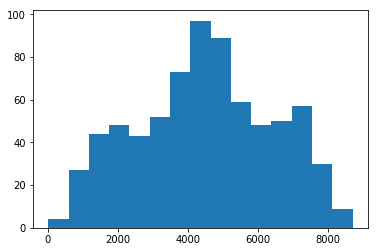

In [116]:
#lets see the distribution of cnt
plt.hist(day.cnt,bins=15)
plt.show()

In [117]:
pd.crosstab(day.season,day.mnth, values = day.temp,aggfunc='mean')

#we observe that each season last on an average of 3 months

mnth,1,2,3,4,5,6,7,8,9,10,11,12
season,,,,,,,,,,,,
1,9.66129,12.267857,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.045455
2,NaN,NaN,16.0,19.233333,24.419355,27.225,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,29.850,31.0,29.048387,25.704545,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.437500,19.870968,15.083333,13.925000


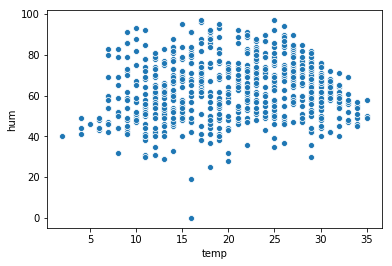

In [118]:
#lets see the distribution of temperature and humidity 
sns.scatterplot(day.temp,day.hum)

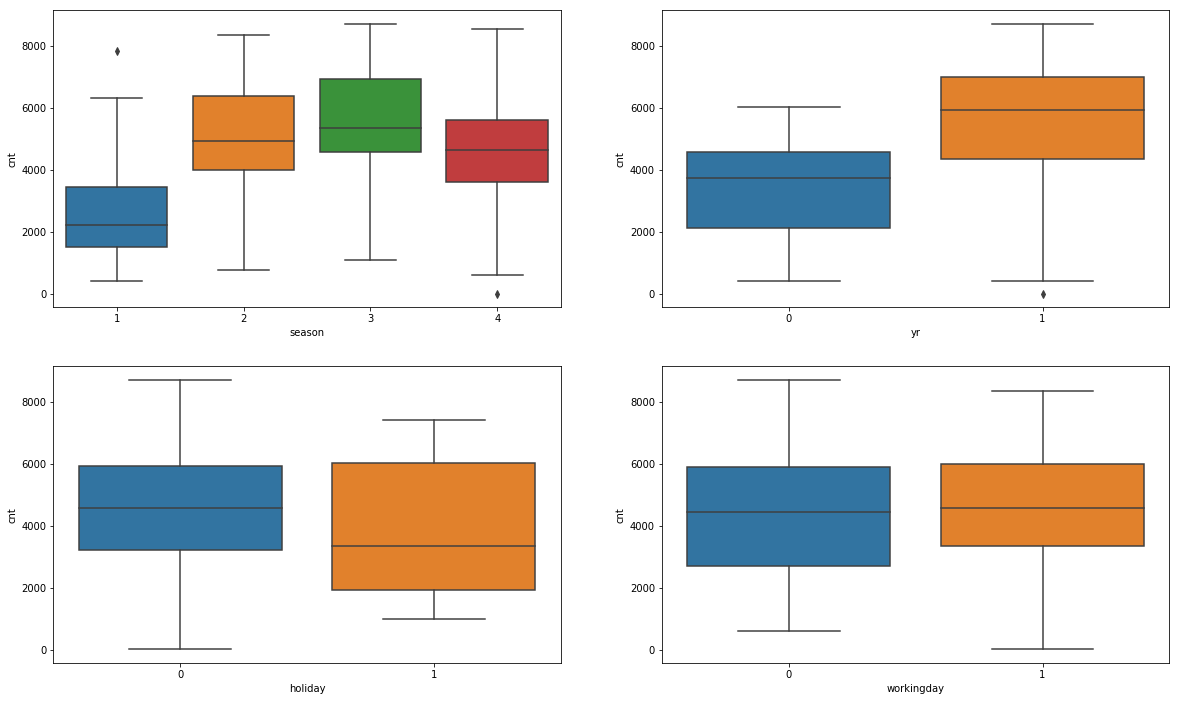

In [119]:
plt.figure(figsize=(20, 12))
plt.subplot(2,2,1)
sns.boxplot(x = 'season', y = 'cnt', data = day)
plt.subplot(2,2,2)
sns.boxplot(x = 'yr', y = 'cnt', data = day)
plt.subplot(2,2,3)
sns.boxplot(x = 'holiday', y = 'cnt', data = day)
plt.subplot(2,2,4)
sns.boxplot(x = 'workingday', y = 'cnt', data = day)
plt.show()

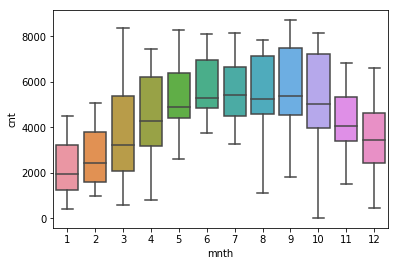

In [120]:
sns.boxplot(x = 'mnth', y = 'cnt' ,data = day)

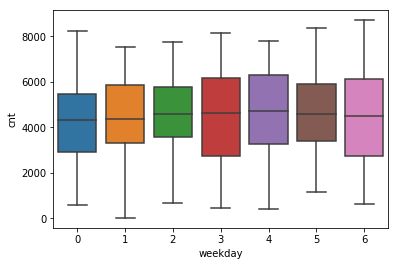

In [121]:
sns.boxplot(x = 'weekday', y = 'cnt', data = day)

#we observe that the overall median is almost constant for the whole week.

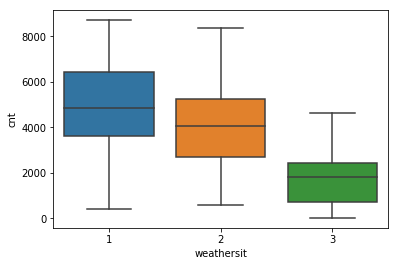

In [122]:
sns.boxplot(x = 'weathersit', y = 'cnt', data = day)

#we see that clear(1) weather has highest value of cnt and light rains(3) has the lowest.

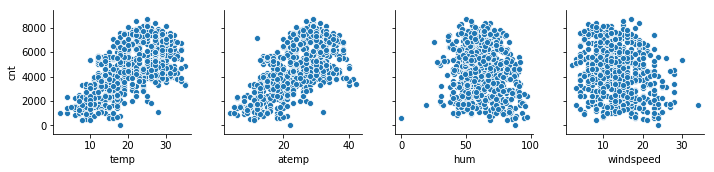

In [123]:
#lets visualize the distribution of numerical variables with cnt
sns.pairplot(x_vars = ['temp','atemp','hum','windspeed'], y_vars='cnt', data=day)

Lets check the correlation between the variables

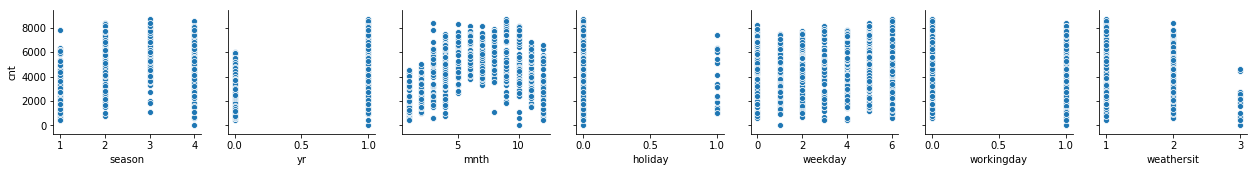

In [124]:
#lets visualize the distribution of categorical variableswith cnt
sns.pairplot(x_vars = ['season','yr','mnth','holiday','weekday','workingday','weathersit'], y_vars='cnt', data=day)

In [125]:
#lets see the correlation
day.corr()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
season,1.000000e+00,-2.248195e-17,8.310321e-01,-0.010868,-0.003081,0.013762,0.021306,0.333352,0.341072,0.206431,-0.230908,0.404584
yr,-2.248195e-17,1.000000e+00,-2.470170e-17,0.008195,-0.005466,-0.002945,-0.050322,0.047677,0.048125,-0.112767,-0.012403,0.569728
mnth,8.310321e-01,-2.470170e-17,1.000000e+00,0.018905,0.009523,-0.004688,0.045613,0.217969,0.224637,0.223504,-0.209957,0.278191
holiday,-1.086804e-02,8.195345e-03,1.890483e-02,1.000000,-0.101962,-0.252948,-0.034395,-0.031342,-0.030854,-0.016183,0.006097,-0.068764
weekday,-3.081198e-03,-5.466369e-03,9.522969e-03,-0.101962,1.000000,0.035800,0.031112,-0.001666,-0.007261,-0.052674,0.016130,0.067534
workingday,1.376178e-02,-2.945396e-03,-4.687953e-03,-0.252948,0.035800,1.000000,0.060236,0.057000,0.053960,0.024499,-0.016726,0.062542
weathersit,2.130636e-02,-5.032247e-02,4.561335e-02,-0.034395,0.031112,0.060236,1.000000,-0.119695,-0.122892,0.591126,0.039104,-0.295929
temp,3.333522e-01,4.767703e-02,2.179688e-01,-0.031342,-0.001666,0.057000,-0.119695,1.000000,0.990281,0.129068,-0.164112,0.627000
atemp,3.410719e-01,4.812480e-02,2.246365e-01,-0.030854,-0.007261,0.053960,-0.122892,0.990281,1.000000,0.139958,-0.189864,0.632085
hum,2.064314e-01,-1.127666e-01,2.235044e-01,-0.016183,-0.052674,0.024499,0.591126,0.129068,0.139958,1.000000,-0.247690,-0.099506


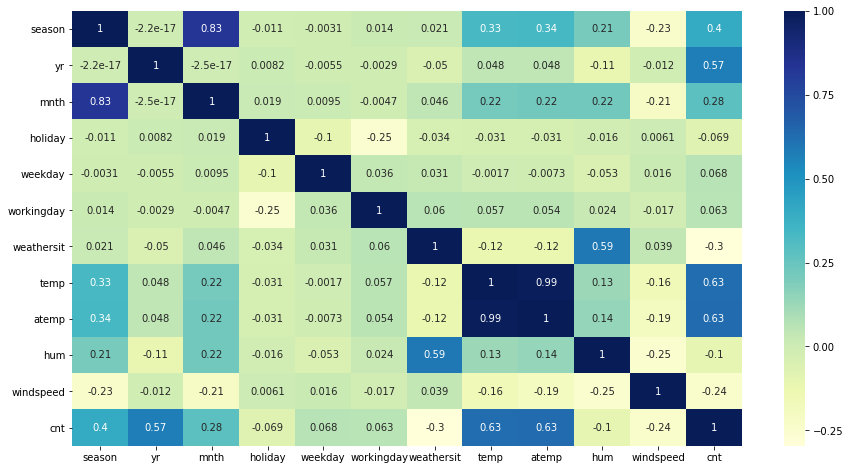

In [126]:
#lets see the correlation
plt.figure(figsize=(15,8), )
sns.heatmap(day.corr(), annot=True,cmap="YlGnBu")

we observe that 
- season has 0.4
- year has 0.57
- mnth has 0.28
- temp has 0.63
- atemp has 0.63


In [127]:
#we observe that temp and atemp have very high correlation 0.99. And that is expected as both columns represent the temperature. 
#this will cause multicollinarity issue later on so lets drop atemp column
day.drop('atemp',inplace=True,axis =1 )

## Data Preparation

Lets create dummy variables for the categorical variables
as the linear regression model does not take categorical values we need to map them 

For the column season

In [128]:
day.season.value_counts()

3    188
2    184
1    180
4    178
Name: season, dtype: int64

In [129]:
day['season'] = day['season'].map({ 1:'spring', 
                                    2:'summer',
                                    3:'fall',
                                    4:'winter' } )

In [130]:
#lets verify if the conversion was proper
day.season.value_counts()

fall      188
summer    184
spring    180
winter    178
Name: season, dtype: int64

For the column month 

In [131]:
day.mnth.value_counts()

12    62
10    62
8     62
7     62
5     62
3     62
1     62
11    60
9     60
6     60
4     60
2     56
Name: mnth, dtype: int64

In [132]:
day['mnth'] = day['mnth'].map({ 1:'jan', 
                                2:'feb',
                                3:'march',
                                4:'april',
                                5:'may', 
                                6:'june',
                                7:'july',
                                8:'august',
                                9:'sept', 
                                10:'oct',
                                11:'nov',
                                12:'dec'
                              } )

In [133]:
day.mnth.value_counts()

dec       62
august    62
jan       62
july      62
oct       62
may       62
march     62
june      60
april     60
nov       60
sept      60
feb       56
Name: mnth, dtype: int64

For the column weekday 

In [134]:
day.weekday.value_counts()

6    105
1    105
0    105
5    104
4    104
2    104
3    103
Name: weekday, dtype: int64

In [135]:
day['weekday'] = day['weekday'].map({ 1:'day 1', 
                                2:'day 2',
                                3:'day 3',
                                4:'day 4',
                                5:'day 5', 
                                6:'day 6',
                                0:'day 0'
                              } )

In [136]:
day.weekday.value_counts()

day 0    105
day 1    105
day 6    105
day 2    104
day 4    104
day 5    104
day 3    103
Name: weekday, dtype: int64

For the column weathersit 

In [137]:
day.weathersit.value_counts()

1    463
2    246
3     21
Name: weathersit, dtype: int64

In [138]:
day['weathersit'] = day['weathersit'].map({ 1:'clear', 
                                            2:'cloudy',
                                            3:'light_rain',
                                            4:'heavy_rain'
                                          } )

In [139]:
day.weathersit.value_counts()

clear         463
cloudy        246
light_rain     21
Name: weathersit, dtype: int64

In [140]:
#lets view hows the data looks now
day.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt
0,spring,0,jan,0,day 6,0,cloudy,14.0,81.0,11.0,985
1,spring,0,jan,0,day 0,0,cloudy,15.0,70.0,17.0,801
2,spring,0,jan,0,day 1,1,clear,8.0,44.0,17.0,1349
3,spring,0,jan,0,day 2,1,clear,8.0,59.0,11.0,1562
4,spring,0,jan,0,day 3,1,clear,9.0,44.0,13.0,1600


In [141]:
day.describe(include='object')

,season,mnth,weekday,weathersit
count,730,730,730,730
unique,4,12,7,3
top,fall,dec,day 0,clear
freq,188,62,105,463


In [142]:
#lets convert the categorical variable into dummy variables 
status1 = pd.get_dummies(day['season'], drop_first=True)
status2 = pd.get_dummies(day['mnth'], drop_first=True)
status3 = pd.get_dummies(day['weekday'], drop_first=True)

#as one value(weathersit category 4 which corresponds to heavy rain and snow) is already not present in the dataset, we will not 
#drop the other column using drop_first
#as that value is not present in our dataset but it can be in one of the test cases or actual scenario, in that case it will be 
#assigned 000
status4 = pd.get_dummies(day['weathersit'])

In [143]:
#add the dummy variables to the dataframe
day = pd.concat([day,status1], axis = 1)
day = pd.concat([day,status2], axis = 1)
day = pd.concat([day,status3], axis = 1)
day = pd.concat([day,status4], axis = 1)

In [144]:
#remove the original columns
day.drop(['season','mnth','weekday','weathersit'],inplace = True,axis = 1)

In [145]:
#lets check the shape now
day.shape

(730, 30)

In [146]:
day.head()

,yr,holiday,workingday,temp,hum,windspeed,cnt,spring,summer,winter,august,dec,feb,jan,july,june,march,may,nov,oct,sept,day 1,day 2,day 3,day 4,day 5,day 6,clear,cloudy,light_rain
0,0,0,0,14.0,81.0,11.0,985,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
1,0,0,0,15.0,70.0,17.0,801,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0,0,1,8.0,44.0,17.0,1349,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
3,0,0,1,8.0,59.0,11.0,1562,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
4,0,0,1,9.0,44.0,13.0,1600,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0


## Splitting the Data into Training and Testing Sets

In [147]:
#lets split the data into train and test as 70-30 

df_train, df_test = train_test_split(day, train_size=0.7, random_state =100)

In [148]:
#lets check the shape
df_train.shape

(510, 30)

In [149]:
df_test.shape

(220, 30)

## Rescaling the Features 

We will use MinMax scaling.

In [150]:
#creating a object of MinMaxScaler class
scalar = MinMaxScaler()

In [151]:
day.head(3)

,yr,holiday,workingday,temp,hum,windspeed,cnt,spring,summer,winter,august,dec,feb,jan,july,june,march,may,nov,oct,sept,day 1,day 2,day 3,day 4,day 5,day 6,clear,cloudy,light_rain
0,0,0,0,14.0,81.0,11.0,985,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
1,0,0,0,15.0,70.0,17.0,801,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0,0,1,8.0,44.0,17.0,1349,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0


In [152]:
#we observe that the following columns have numerical values
num_var = ['temp','hum','windspeed','cnt']

#lets scale them
df_train[num_var] = scalar.fit_transform(df_train[num_var])

In [153]:
#view the data
df_train.head()

,yr,holiday,workingday,temp,hum,windspeed,cnt,spring,summer,winter,august,dec,feb,jan,july,june,march,may,nov,oct,sept,day 1,day 2,day 3,day 4,day 5,day 6,clear,cloudy,light_rain
576,1,0,1,0.818182,0.721649,0.258065,0.827658,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
426,1,0,0,0.454545,0.639175,0.258065,0.465255,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0
728,1,0,0,0.242424,0.494845,0.677419,0.204096,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
482,1,0,0,0.393939,0.505155,0.193548,0.482973,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
111,0,0,1,0.363636,0.752577,0.387097,0.191095,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0


In [154]:
#we see that all values are between 0 and 1
df_train[num_var].describe()

,temp,hum,windspeed,cnt
count,510.000000,510.000000,510.000000,510.000000
mean,0.548901,0.650859,0.317584,0.513499
std,0.226311,0.146133,0.170686,0.224421
min,0.000000,0.000000,0.000000,0.000000
25%,0.363636,0.536082,0.193548,0.356420
50%,0.545455,0.649485,0.290323,0.518638
75%,0.757576,0.752577,0.419355,0.684710
max,1.000000,1.000000,1.000000,1.000000


In [155]:
# lets see for the whole dataset
df_train.describe()

,yr,holiday,workingday,temp,hum,windspeed,cnt,spring,summer,winter,august,dec,feb,jan,july,june,march,may,nov,oct,sept,day 1,day 2,day 3,day 4,day 5,day 6,clear,cloudy,light_rain
count,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000
mean,0.507843,0.025490,0.676471,0.548901,0.650859,0.317584,0.513499,0.243137,0.247059,0.247059,0.096078,0.084314,0.066667,0.088235,0.076471,0.076471,0.098039,0.084314,0.086275,0.084314,0.080392,0.150980,0.131373,0.158824,0.133333,0.127451,0.154902,0.625490,0.345098,0.029412
std,0.500429,0.157763,0.468282,0.226311,0.146133,0.170686,0.224421,0.429398,0.431725,0.431725,0.294988,0.278131,0.249689,0.283915,0.266010,0.266010,0.297660,0.278131,0.281045,0.278131,0.272166,0.358381,0.338139,0.365870,0.340268,0.333805,0.362166,0.484471,0.475867,0.169124
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.363636,0.536082,0.193548,0.356420,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,1.000000,0.545455,0.649485,0.290323,0.518638,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,0.757576,0.752577,0.419355,0.684710,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Dividing into X(independant variable) and Y(dependant variable) sets for the model building

In [156]:
#dependant variable 
y_train = df_train.pop('cnt')

#independant variable
X_train = df_train

## Building our model

### RFE  - Recursive Feature Elimination



In [157]:
# Running RFE with the output number of the variable equal to 15
#as we have decided to keep 10 or less columns in our final model lets start with 15
#and then manually determine which are important

lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, 15)             
rfe = rfe.fit(X_train, y_train)

In [158]:
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('yr', True, 1),
 ('holiday', True, 1),
 ('workingday', True, 1),
 ('temp', True, 1),
 ('hum', True, 1),
 ('windspeed', True, 1),
 ('spring', False, 11),
 ('summer', False, 3),
 ('winter', True, 1),
 ('august', False, 4),
 ('dec', False, 8),
 ('feb', False, 7),
 ('jan', False, 6),
 ('july', False, 12),
 ('june', False, 13),
 ('march', False, 15),
 ('may', False, 10),
 ('nov', False, 9),
 ('oct', False, 14),
 ('sept', False, 2),
 ('day 1', True, 1),
 ('day 2', True, 1),
 ('day 3', True, 1),
 ('day 4', True, 1),
 ('day 5', True, 1),
 ('day 6', False, 5),
 ('clear', True, 1),
 ('cloudy', True, 1),
 ('light_rain', True, 1)]

In [159]:
#the choosen columns
col = X_train.columns[rfe.support_]
col

Index(['yr', 'holiday', 'workingday', 'temp', 'hum', 'windspeed', 'winter',
       'day 1', 'day 2', 'day 3', 'day 4', 'day 5', 'clear', 'cloudy',
       'light_rain'],
      dtype='object')

In [160]:
#the discarded columns
X_train.columns[~rfe.support_]

Index(['spring', 'summer', 'august', 'dec', 'feb', 'jan', 'july', 'june',
       'march', 'may', 'nov', 'oct', 'sept', 'day 6'],
      dtype='object')

### Building model using statsmodel, for the detailed statistics

In [161]:
# Creating X_test dataframe with RFE selected variables
X_train_sm = X_train[col]

#adding constant for the intercept 


In [162]:
#function to run the linear model and get the statistic summary 
def fit_lr(x,y):
    
    #running the linear model
    lr = sm.OLS(y,x)
    lr_model = lr.fit()
    #printing the summary of the model 
    print(lr_model.summary())
    return(lr_model)

In [163]:
#function to calculate vif
def check_vif(x):
    x = x.drop(['const'], axis=1)
    vif = pd.DataFrame()
    vif['Features'] = x.columns
    vif['VIF'] = [variance_inflation_factor(x.values,i) for i in range(x.shape[1])]
    vif['VIF'] = round(vif['VIF'],2)
    vif = vif.sort_values(by = 'VIF',ascending=False)
    print(vif)

lets keep this a guideline to keep or remove the column
- high pvalue   high vif    remove first
- high pvalue   low vif     remove second
- low  pvalue   high vif    remove third
- low  pvalue   low vif     keep the column   

In [164]:
#checking the statistics for the columns we got from RFE
fit_lr(X_train_sm,y_train)
check_vif(X_train_sm)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.804
Model:                            OLS   Adj. R-squared:                  0.799
Method:                 Least Squares   F-statistic:                     156.9
Date:                Mon, 04 Jan 2021   Prob (F-statistic):          2.90e-166
Time:                        20:48:57   Log-Likelihood:                 455.03
No. Observations:                 510   AIC:                            -882.1
Df Residuals:                     496   BIC:                            -822.8
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0779      0.027      2.856      0.0

In [165]:
#we observe that 'day 3' has high p_value= 0.995 and very high VIF = inf
#so lets drop that column 
X_train_new = X_train_sm.drop(["day 3"], axis = 1)

#now lets see how the model is 
lr_model = fit_lr(X_train_new,y_train)
check_vif(X_train_new)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.804
Model:                            OLS   Adj. R-squared:                  0.799
Method:                 Least Squares   F-statistic:                     156.9
Date:                Mon, 04 Jan 2021   Prob (F-statistic):          2.90e-166
Time:                        20:48:57   Log-Likelihood:                 455.03
No. Observations:                 510   AIC:                            -882.1
Df Residuals:                     496   BIC:                            -822.8
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0779      0.027      2.856      0.0

In [166]:
#we see that day 5 has high p_value = 0.933, so lets drop it even thought VIF is 1.60
X_train_new = X_train_new.drop(["day 5"], axis = 1)
#checking the statistics for the columns new columns
lr_model = fit_lr(X_train_new,y_train)
check_vif(X_train_new)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.804
Model:                            OLS   Adj. R-squared:                  0.800
Method:                 Least Squares   F-statistic:                     170.4
Date:                Mon, 04 Jan 2021   Prob (F-statistic):          2.19e-167
Time:                        20:48:57   Log-Likelihood:                 455.02
No. Observations:                 510   AIC:                            -884.0
Df Residuals:                     497   BIC:                            -829.0
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0778      0.027      2.857      0.0

In [167]:
#we see that day 4 has high p_value = 0.639, so lets drop it even thought VIF is 1.28
X_train_new = X_train_new.drop(["day 4"], axis = 1)

#checking the statistics for the columns new columns
lr_model = fit_lr(X_train_new,y_train)
check_vif(X_train_new)


                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.804
Model:                            OLS   Adj. R-squared:                  0.800
Method:                 Least Squares   F-statistic:                     186.1
Date:                Mon, 04 Jan 2021   Prob (F-statistic):          1.74e-168
Time:                        20:48:57   Log-Likelihood:                 454.91
No. Observations:                 510   AIC:                            -885.8
Df Residuals:                     498   BIC:                            -835.0
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0777      0.027      2.855      0.0

In [168]:
#we see that day 2 has high p_value = 0.358, so lets drop it even thought VIF is 1.15
X_train_new = X_train_new.drop(["day 2"], axis = 1)

#checking the statistics for the columns new columns
lr_model = fit_lr(X_train_new,y_train)
check_vif(X_train_new)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.804
Model:                            OLS   Adj. R-squared:                  0.800
Method:                 Least Squares   F-statistic:                     204.7
Date:                Mon, 04 Jan 2021   Prob (F-statistic):          1.81e-169
Time:                        20:48:57   Log-Likelihood:                 454.48
No. Observations:                 510   AIC:                            -887.0
Df Residuals:                     499   BIC:                            -840.4
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0788      0.027      2.899      0.0

In [169]:
#we see that day 1 has high p_value = 0.401, so lets drop it even thought VIF is 1.17
X_train_new = X_train_new.drop(["day 1"], axis = 1)

#checking the statistics for the columns new columns
lr_model = fit_lr(X_train_new,y_train)
check_vif(X_train_new)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.804
Model:                            OLS   Adj. R-squared:                  0.800
Method:                 Least Squares   F-statistic:                     227.5
Date:                Mon, 04 Jan 2021   Prob (F-statistic):          1.66e-170
Time:                        20:48:57   Log-Likelihood:                 454.12
No. Observations:                 510   AIC:                            -888.2
Df Residuals:                     500   BIC:                            -845.9
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0796      0.027      2.929      0.0

In [170]:
#we see that working has high p_value = 0.073, so lets drop it even thought VIF is 1.07
X_train_new = X_train_new.drop(["workingday"], axis = 1)

#checking the statistics for the columns 
lr_model = fit_lr(X_train_new,y_train)
check_vif(X_train_new)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.802
Model:                            OLS   Adj. R-squared:                  0.799
Method:                 Least Squares   F-statistic:                     254.4
Date:                Mon, 04 Jan 2021   Prob (F-statistic):          5.02e-171
Time:                        20:48:57   Log-Likelihood:                 452.47
No. Observations:                 510   AIC:                            -886.9
Df Residuals:                     501   BIC:                            -848.8
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0892      0.027      3.341      0.0

In [171]:
#now we observe that all pvalues are less than 0.05 but some columns have very high VIF
#so lets handle those, we can drop those column if they dont affect our r_square much 


In [172]:
#lets remove clear also if it doesnt affect our accuracy much
X_train_new = X_train_new.drop(["clear"], axis = 1)
lr_model = fit_lr(X_train_new,y_train)
check_vif(X_train_new)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.802
Model:                            OLS   Adj. R-squared:                  0.799
Method:                 Least Squares   F-statistic:                     254.4
Date:                Mon, 04 Jan 2021   Prob (F-statistic):          5.02e-171
Time:                        20:48:58   Log-Likelihood:                 452.47
No. Observations:                 510   AIC:                            -886.9
Df Residuals:                     501   BIC:                            -848.8
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2125      0.030      7.144      0.0

In [173]:
#lets remove hum also if it doesnt affect our accuracy much
X_train_new = X_train_new.drop(["hum"], axis = 1)
lr_model = fit_lr(X_train_new,y_train)
check_vif(X_train_new)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.798
Model:                            OLS   Adj. R-squared:                  0.795
Method:                 Least Squares   F-statistic:                     282.6
Date:                Mon, 04 Jan 2021   Prob (F-statistic):          1.26e-169
Time:                        20:48:58   Log-Likelihood:                 446.27
No. Observations:                 510   AIC:                            -876.5
Df Residuals:                     502   BIC:                            -842.7
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1297      0.018      7.068      0.0

In [174]:
#we observe that now all the columns have pvalue < 0.5 and all vif are < 5 
#we observe that Prob (F-statistic) is very small, hence the overall fit to the model is significant. 

## Residual Analysis of the train data

In [175]:
y_train_pred = lr_model.predict(X_train_new)

Text(0.5,0,'Errors')

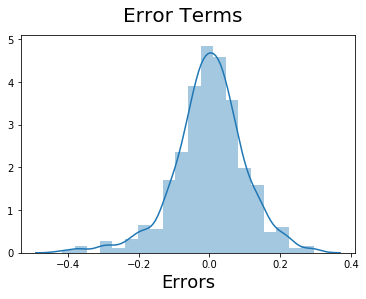

In [176]:
# Plot the histogram of the error terms
fig = plt.figure()
sns.distplot((y_train - y_train_pred), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                  
plt.xlabel('Errors', fontsize = 18)  

#we observe that the error terms are normally distributed with mean at 0

In [177]:
sum_of_residuals = y_train - y_train_pred
sum_of_residuals.sum()

#we see the sum of very small and can be approximated to zero. 

3.552713678800501e-15

## Making Predictions

#### Applying the scaling on the test sets

In [178]:
#we observe that the following columns have numerical values
num_var = ['temp','hum','windspeed','cnt']

#lets scale them
df_test[num_var] = scalar.transform(df_test[num_var])

#### Dividing into X_test and y_test

In [179]:
y_test = df_test.pop('cnt')
X_test = df_test

In [180]:
# Now let's use our model to make predictions.

# Adding a constant variable 
X_test_new = sm.add_constant(X_test)

In [181]:
X_test_new = X_test_new[X_train_new.columns]

In [182]:
# Making predictions
y_test_pred = lr_model.predict(X_test_new)

In [183]:
#test set
r2_score(y_true= y_test, y_pred=y_test_pred)

0.7723381864625006

## Model Evaluation

Text(0,0.5,'y__test_pred')

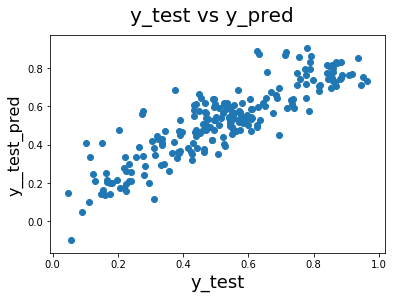

In [184]:
# Plotting y_test and y_pred to understand the spread.
fig = plt.figure()
plt.scatter(y_test,y_test_pred)
fig.suptitle('y_test vs y_pred', fontsize=20)              # Plot heading 
plt.xlabel('y_test', fontsize=18)                          # X-label
plt.ylabel('y__test_pred', fontsize=16)                          # Y-label

# we observe that the error terms are independent and have constant variance


We can see that the equation of our best fitted line is:

$ cnt = 0.5837  \times  temp + 0.2329  \times  yr + (-0.0958) \times holiday + (-0.1443) \times windspeed + 0.1040 \times winter + (-0.0702) \times cloudy + (-0.2742) \times light rain  + 0.1297 $


In [185]:
#train set
r2_score(y_true= y_train, y_pred=y_train_pred)

0.7976004877931668

In [186]:
#test set
r2_score(y_true= y_test, y_pred=y_test_pred)

0.7723381864625006

with 
- train r_score being 0.79
- test r_score being 0.77